In [160]:
# util
import pandas as pd
import numpy as np
import re
import string
import pickle

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Load Data

In [161]:
%%time

files = "twitter_sentiment.csv" 
col_names = ["target", "id", "date", "flag", "user", "text"]
chunk = pd.read_csv(files, chunksize=100000, encoding='ISO-8859-1', names=col_names)
concat_df = pd.concat(chunk)

Wall time: 4.19 s


In [162]:
concat_df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Data Prep

In [163]:
df2 = concat_df.sample(10000, random_state=1, ignore_index=True).drop(columns=["id", "date", "flag", "user"])
df2.head()

,target,text
0,0,i miss nikki nu nu already shes always there ...
1,0,So I had a dream last night. I remember a sig...
2,0,@girlyghost ohh poor sickly you (((hugs)) ho...
3,0,it is raining again
4,0,@MissKeriBaby wish I was in LA right now


In [164]:
df = concat_df.drop(columns=["id", "date", "flag", "user"]).sample(frac=1).reset_index(drop=True)
df.shape

(1600000, 2)

In [165]:
sentiment_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return sentiment_map[int(label)]

In [166]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))
df.head()

Wall time: 510 ms


,target,text
0,NEGATIVE,Abort! Its raining.
1,NEGATIVE,Well I have a lonely but FUN day-first I stay ...
2,NEGATIVE,@caradae They offered a debt management progra...
3,POSITIVE,"jason, your clothes are dry. get them out of m..."
4,POSITIVE,Just figured out how to sign on to this thingâ...


Text(0.5, 1.0, 'Distribution of data')

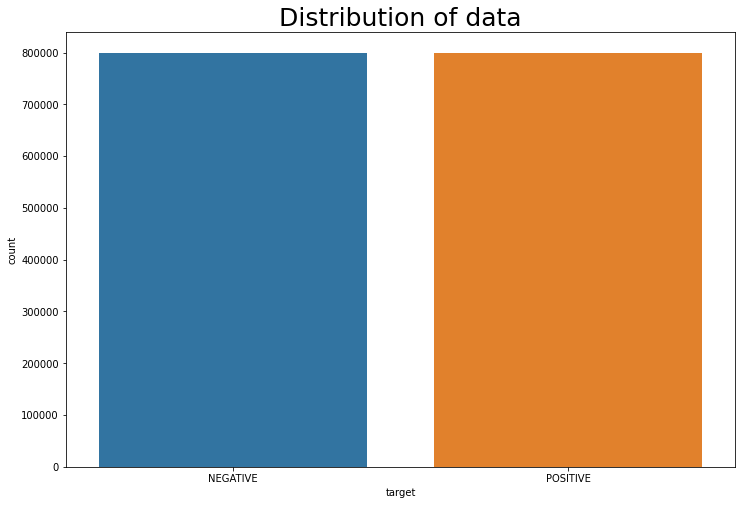

In [167]:
plt.figure(figsize=(12,8))
sns.countplot(x="target", data=df)
plt.title("Distribution of data", fontsize=25)

In [168]:
%%time

# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

def text_cleaning(text):
    
    stop_words = stopwords.words('english')
    lemma = WordNetLemmatizer()
    
    for emoji in emojis.keys():
        text = text.replace(emoji, "EMOJI" + emojis[emoji])
    text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(text).lower()).strip()
    text = ' '.join([lemma.lemmatize(word) for word in word_tokenize(text) if word not in (stop_words)])
    return text

df['cleaned_text'] = df['text'].apply(lambda x: text_cleaning(x))


Wall time: 13min 1s


In [169]:
df.head()

,target,text,cleaned_text
0,NEGATIVE,Abort! Its raining.,abort raining
1,NEGATIVE,Well I have a lonely but FUN day-first I stay ...,well lonely fun day first stay home 5 get go b...
2,NEGATIVE,@caradae They offered a debt management progra...,offered debt management program cc become one ...
3,POSITIVE,"jason, your clothes are dry. get them out of m...",jason clothes dry get way
4,POSITIVE,Just figured out how to sign on to this thingâ...,figured sign thing yeayy


## POSITIVE

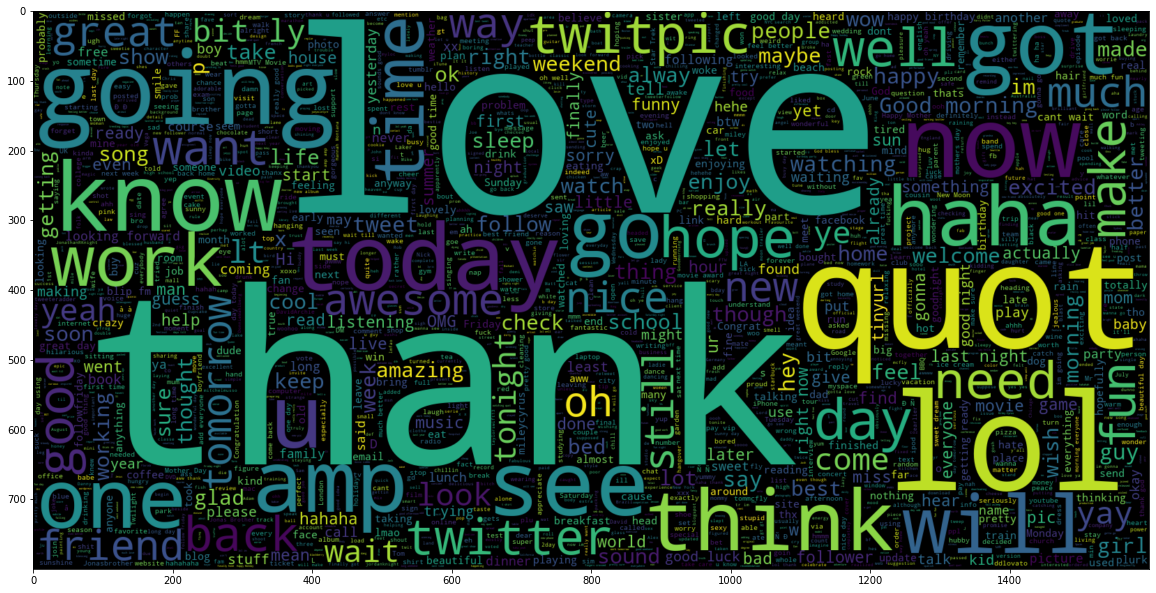

In [170]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.target == 'POSITIVE'].text))
plt.imshow(wc , interpolation = 'bilinear')

## NEGATIVE

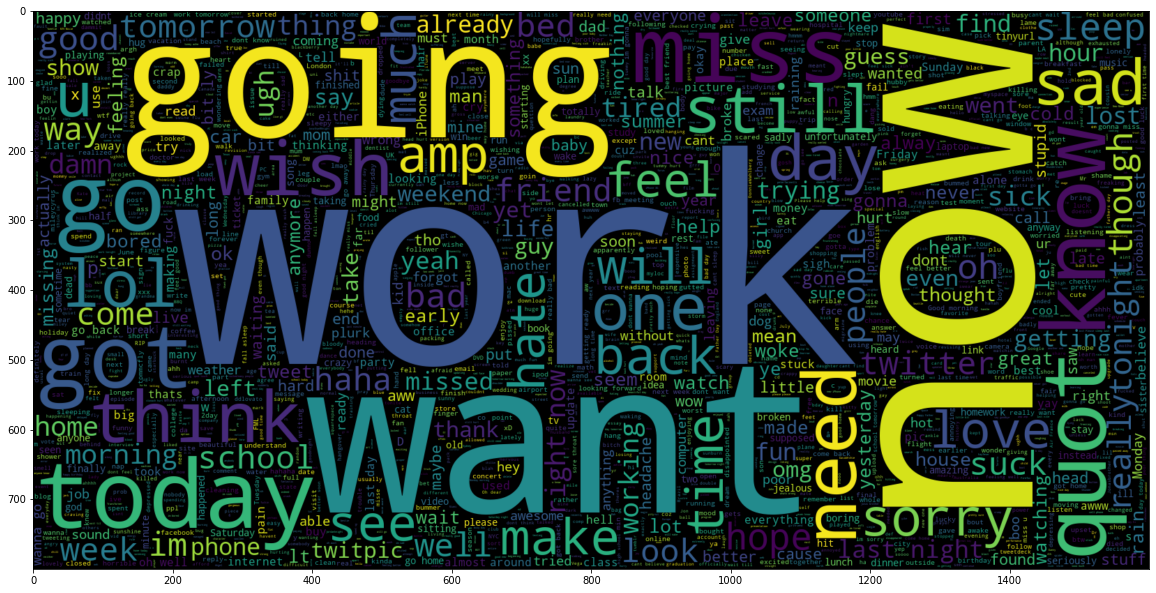

In [171]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.target == 'NEGATIVE'].text))
plt.imshow(wc , interpolation = 'bilinear')

# Modelling

In [172]:
from sklearn.model_selection import train_test_split

x = df['cleaned_text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)



In [173]:
vectorizer = TfidfVectorizer()
train_x_vectors = vectorizer.fit_transform(X_train)

In [174]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [175]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

# Naive Bayes

              precision    recall  f1-score   support

    NEGATIVE       0.77      0.77      0.77    239798
    POSITIVE       0.77      0.77      0.77    240202

    accuracy                           0.77    480000
   macro avg       0.77      0.77      0.77    480000
weighted avg       0.77      0.77      0.77    480000



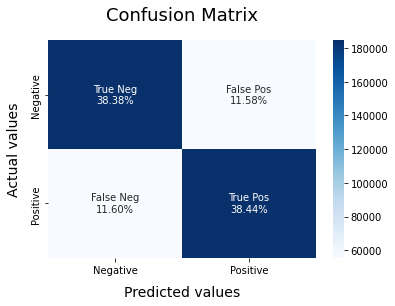

In [176]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

# SVM

              precision    recall  f1-score   support

    NEGATIVE       0.78      0.75      0.77    239798
    POSITIVE       0.76      0.79      0.77    240202

    accuracy                           0.77    480000
   macro avg       0.77      0.77      0.77    480000
weighted avg       0.77      0.77      0.77    480000



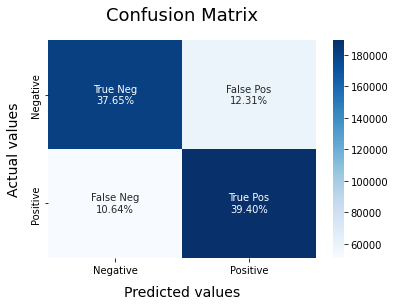

In [177]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

# Logistic Regression

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.76      0.77    239798
    POSITIVE       0.77      0.79      0.78    240202

    accuracy                           0.78    480000
   macro avg       0.78      0.78      0.78    480000
weighted avg       0.78      0.78      0.78    480000



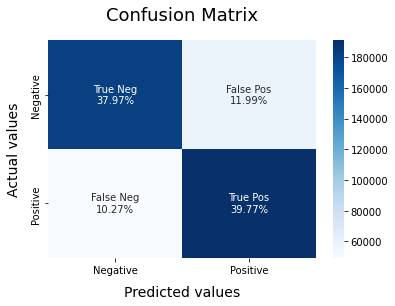

In [178]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [188]:
inputs = "Genshin is such a boring game @caviarminus"
cleaning = text_cleaning(inputs)
print(cleaning)

X_test = vectorizer.transform([cleaning])
sentiment = LRmodel.predict(X_test)
sentiment

genshin boring game caviarminus


array(['NEGATIVE'], dtype=object)